In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from weac.components import Segment, ScenarioConfig, WeakLayer, CriteriaConfig
from weac.analysis import CriteriaEvaluator
from weac.utils.snowpilot_parser import convert_to_mm, convert_to_deg

from layerwise.analysis.profile_utils import load_snowpilot_parsers, eval_avalanche_pit

In [3]:
## Settings
run_weac = True
dev = False
discard_pits_with_wl_above = 50 # mm

## Setup standard values

raw_data_dir = "../data/raw/snowpilot"
csv_file = "../data/crown_flank_dataset.csv"

phi = 0.0
wl_spacing = 50 # mm

scenario_config = ScenarioConfig(system_type="skier", phi=phi)
weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=6.16, tau_c=5.09)
segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
criteria_config = CriteriaConfig()
criteria_evaluator = CriteriaEvaluator(criteria_config)

In [4]:
## Parse all snowpilot files near an avalanche and a layer of concern

paths, parsers = load_snowpilot_parsers(raw_data_dir)

print("Overall number of files:", len(paths))

paths_and_parsers = [
    (fp, pars)
    for fp, pars in zip(paths, parsers)
]

paths_and_parsers_near_avalanche = [
    (fp, p)
    for fp, p in paths_and_parsers
    if bool(p.snowpit.core_info.location.pit_near_avalanche)
]

print("Number of files near avalanche:", len(paths_and_parsers_near_avalanche))

avalanche_pits_with_layer_of_concern = [
    (fp, p)
    for fp, p in paths_and_parsers_near_avalanche
    if bool(p.snowpit.snow_profile.layer_of_concern)
]

print("Number of files with layer of concern:", len(avalanche_pits_with_layer_of_concern))

if dev:
    avalanche_pits_with_layer_of_concern = avalanche_pits_with_layer_of_concern[:5]


Overall number of files: 31170
Number of files near avalanche: 945
Number of files with layer of concern: 848


In [5]:
# Extract additional pit information

pit_info_list = []
for _, pit in avalanche_pits_with_layer_of_concern:
    depth_top = pit.snowpit.snow_profile.layer_of_concern.depth_top
    if depth_top:
        depth_top_mm = depth_top[0] * convert_to_mm[depth_top[1]]
    else:
        depth_top_mm = None
    thickness = pit.snowpit.snow_profile.layer_of_concern.thickness
    if thickness:
        thickness_mm = thickness[0] * convert_to_mm[thickness[1]]
    else:
        thickness_mm = None
    slope_angle = pit.snowpit.core_info.location.slope_angle
    if slope_angle:
        slope_angle_deg = slope_angle[0] * convert_to_deg[slope_angle[1]]
    else:
        slope_angle_deg = 0.0
    hs = pit.snowpit.snow_profile.hs
    if hs:
        hs_mm = hs[0] * convert_to_mm[hs[1]]
    else:
        hs_mm = None
    profile_depth = pit.snowpit.snow_profile.profile_depth
    if profile_depth:
        profile_depth_mm = profile_depth[0] * convert_to_mm[profile_depth[1]]
    else:
        profile_depth_mm = None
    pit_near_avalanche_location = pit.snowpit.core_info.location.pit_near_avalanche_location
    pit_info_dict = {
        "Slope Angle": slope_angle_deg,
        "HS": hs_mm,
        "Profile Depth": profile_depth_mm,
        "Pit Near Avalanche Location": pit_near_avalanche_location,
        "WL_Depth": depth_top_mm,
        "WL_Thickness": thickness_mm,
    }
    pit_info_list.append(pit_info_dict)

print(pit_info_list)

[{'Slope Angle': '23', 'HS': None, 'Profile Depth': 1000.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 800.0, 'WL_Thickness': 10.0}, {'Slope Angle': '42', 'HS': 930.0, 'Profile Depth': 930.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 390.0, 'WL_Thickness': 10.0}, {'Slope Angle': '28', 'HS': 1350.0, 'Profile Depth': 1350.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 300.0, 'WL_Thickness': 10.0}, {'Slope Angle': '24', 'HS': 740.0, 'Profile Depth': 740.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 480.0, 'WL_Thickness': 260.0}, {'Slope Angle': '28', 'HS': 2000.0, 'Profile Depth': 1250.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 90.0, 'WL_Thickness': 290.0}, {'Slope Angle': '27', 'HS': 1750.0, 'Profile Depth': 1750.0, 'Pit Near Avalanche Location': 'flank', 'WL_Depth': 1170.0, 'WL_Thickness': 10.0}, {'Slope Angle': '38', 'HS': 710.0, 'Profile Depth': 710.0, 'Pit Near Avalanche Location': 'crown', 'WL_Depth': 350.0, 'WL_Thickness': 10.0}, {'Sl

In [6]:
if run_weac:
    data_rows = []
    error_pits = []
    for (fp, pit), pit_info_dict in tqdm(
        zip(avalanche_pits_with_layer_of_concern, pit_info_list),
        total=len(avalanche_pits_with_layer_of_concern),
        desc="Processing avalanche pits",
    ):
        scenario_config = ScenarioConfig(
            phi=pit_info_dict["Slope Angle"],
            system_type="skier",
        )
        try:
            pit_info_dict, layers, weaklayer = eval_avalanche_pit(
                pit, 
                pit_info_dict, 
                scenario_config, 
                segments, 
                weak_layer,
                criteria_evaluator)
            data_rows.append(pit_info_dict)
        except Exception as e:
            error_pits.append(pit)
            print(f"Error processing pit {pit.snowpit.core_info.pit_id}: {e}")
            continue

    print(f"Number of pits with errors: {len(error_pits)}")
    print(f"Number of pits processed: {len(data_rows)}")
    print(f"Number of pits total: {len(avalanche_pits_with_layer_of_concern)}")

    df = pd.DataFrame(data_rows)
    print(df.head())
    df.to_csv(csv_file, index=False)
else:
    df = pd.read_csv(csv_file)

Processing avalanche pits:   0%|          | 0/848 [00:00<?, ?it/s]

Error processing pit 21585: 1 validation error for ModelInput
  Value error, At least one layer is required [type=value_error, input_value={'weak_layer': WeakLayer(...oundation=True, m=0.0)]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error
Error processing pit 21585: 1 validation error for ModelInput
  Value error, At least one layer is required [type=value_error, input_value={'weak_layer': WeakLayer(...oundation=True, m=0.0)]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error
Error processing pit 21142: Layer is missing density information; density profile, hand hardness and grain type are all missing. Excluding SnowPit from calculations.
Error processing pit 17994: 1 validation error for ModelInput
  Value error, At least one layer is required [type=value_error, input_value={'weak_layer': WeakLayer(...oundation=True, m=0.0)]}, input_type=dict]
    For further information visit https://

In [7]:
sserr_median = df["sserr_result"].median()
sserr_mean = df["sserr_result"].mean()
sserr_std = df["sserr_result"].std()

print(f"SSERR Median: {sserr_median}")
print(f"SSERR Mean: {sserr_mean}")
print(f"SSERR Std: {sserr_std}")

cc_median = df["coupled_criterion"].median()
cc_mean = df["coupled_criterion"].mean()
cc_std = df["coupled_criterion"].std()

print(f"CC Median: {cc_median}")
print(f"CC Mean: {cc_mean}")
print(f"CC Std: {cc_std}")

max_stress_median = df["max_stress"].median()
max_stress_mean = df["max_stress"].mean()
max_stress_std = df["max_stress"].std()

print(f"MAX STRESS Median: {max_stress_median}")
print(f"MAX STRESS Mean: {max_stress_mean}")
print(f"MAX STRESS Std: {max_stress_std}")

ss_max_Sxx_norm_median = df["ss_max_Sxx_norm"].median()
ss_max_Sxx_norm_mean = df["ss_max_Sxx_norm"].mean()
ss_max_Sxx_norm_std = df["ss_max_Sxx_norm"].std()

print(f"SS MAX SXX NORM Median: {ss_max_Sxx_norm_median}")
print(f"SS MAX SXX NORM Mean: {ss_max_Sxx_norm_mean}")
print(f"SS MAX SXX NORM Std: {ss_max_Sxx_norm_std}")


SSERR Median: 4.024535715519939
SSERR Mean: 4.836829335808256
SSERR Std: 3.441888095245157
CC Median: 213.83001170235747
CC Mean: 215.83341129399844
CC Std: 103.73440022528266
MAX STRESS Median: 0.024306698596225786
MAX STRESS Mean: 0.0530348593661094
MAX STRESS Std: 0.10158085680913116
SS MAX SXX NORM Median: 1.8910619582214314
SS MAX SXX NORM Mean: 2.0446595751635654
SS MAX SXX NORM Std: 0.6496153660009376


In [8]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["impact_criterion"], mode="markers", name="Impact Criterion", marker=dict(color="red")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Impact Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["coupled_criterion"], mode="markers", name="Coupled Criterion", marker=dict(color="blue")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Coupled Criterion")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["sserr_result"], mode="markers", name="SSERR", marker=dict(color="green")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="SSERR")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["touchdown_distance"], mode="markers", name="Touchdown Distance", marker=dict(color="yellow")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Touchdown Distance")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["max_stress"], mode="markers", name="Max Stress", marker=dict(color="yellow")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="Max Stress")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df["WL_Depth"], y=df["ss_max_Sxx_norm"], mode="markers", name="SS MAX SXX NORM", marker=dict(color="yellow")))
fig.update_layout(xaxis_title="WL Depth (mm)", yaxis_title="SS MAX SXX NORM")
fig.show()


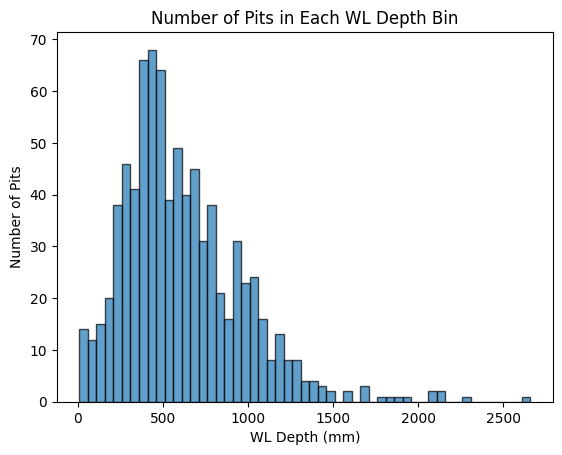

In [9]:
import matplotlib.pyplot as plt

# Bin wl depths according to 10 mm intervals
wl_depths = df["WL_Depth"]
max_wl_depth = max(wl_depths)
min_wl_depth = min(wl_depths)

# Create bins
bin_width = 50
bins = np.arange(min_wl_depth, max_wl_depth + bin_width, bin_width)

# Use matplotlib's histogram which handles this automatically
plt.hist(wl_depths, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("WL Depth (mm)")
plt.ylabel("Number of Pits")
plt.title("Number of Pits in Each WL Depth Bin")
plt.show()

In [10]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

wl_depths = df["WL_Depth"]
df = df[df["WL_Depth"] > discard_pits_with_wl_above]

### Coupled Criterion

In [11]:
# Plot cumulative distribution of coupled criterion
cc = df["coupled_criterion"][~np.isnan(df["coupled_criterion"])]
sorted_cc = np.sort(cc)
cdf = np.arange(1, len(sorted_cc) + 1) / len(sorted_cc)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf, mode="markers", name="Coupled Criterion", marker=dict(color="red")))
fig.update_layout(xaxis_title="Weight (kg)", yaxis_title="Cumulative Distribution")
fig.show()

In [12]:
from scipy import stats

# Fit a normal distribution to the data
params_norm = stats.norm.fit(cc)
cdf_values_norm = stats.norm.cdf(sorted_cc, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(cc)
cdf_values_lognorm = stats.lognorm.cdf(sorted_cc, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
# params_expon = stats.expon.fit(cc)
# cdf_values_expon = stats.expon.cdf(sorted_cc, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(cc)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_cc, *params_exponnorm)


fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
# fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_cc, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(0.16659808869746978), np.float64(-393.01125799319584), np.float64(603.4546278244538))


/home/pillowbeast/Documents/layerwise/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6930: RuntimeWarning:

divide by zero encountered in log



In [13]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Plot cumulative distribution of coupled criterion
sserr = df["sserr_result"][~np.isnan(df["sserr_result"])]
sorted_sserr = np.sort(sserr)
cdf = np.arange(1, len(sorted_sserr) + 1) / len(sorted_sserr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf, mode="markers", name="SSERR", marker=dict(color="red")))
fig.update_layout(xaxis_title="SSERR", yaxis_title="Cumulative Distribution")
fig.show()


In [14]:
from scipy import stats

# # Fit a normal distribution to the data
# params_norm = stats.norm.fit(sserr)
# cdf_values_norm = stats.norm.cdf(sorted_sserr, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(sserr)
cdf_values_lognorm = stats.lognorm.cdf(sorted_sserr, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
# params_expon = stats.expon.fit(sserr)
# cdf_values_expon = stats.expon.cdf(sorted_sserr, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(sserr)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_sserr, *params_exponnorm)


fig = go.Figure()
# fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
# fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_sserr, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(0.5709264240928602), -0.5320049310557289, np.float64(4.628583572796516))


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Plot cumulative distribution of coupled criterion
max_stress = df["max_stress"][~np.isnan(df["max_stress"])]
sorted_max_stress = np.sort(max_stress)
cdf = np.arange(1, len(sorted_max_stress) + 1) / len(sorted_max_stress)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf, mode="markers", name="max_stress", marker=dict(color="red")))
fig.update_layout(xaxis_title="max_stress", yaxis_title="Cumulative Distribution")
fig.show()


808
808


In [16]:
from scipy import stats

# # Fit a normal distribution to the data
params_norm = stats.norm.fit(max_stress)
cdf_values_norm = stats.norm.cdf(sorted_max_stress, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(max_stress)
cdf_values_lognorm = stats.lognorm.cdf(sorted_max_stress, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
params_expon = stats.expon.fit(max_stress)
cdf_values_expon = stats.expon.cdf(sorted_max_stress, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(max_stress)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_max_stress, *params_exponnorm)


fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_max_stress, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(1.2979546316112562), -0.0005139743272564596, np.float64(0.024507949142599624))


## Steady State S_xx (normalized)

In [17]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Plot cumulative distribution of coupled criterion
weight = np.arange(0, 600, 10)
ss_max_Sxx_norm = df["ss_max_Sxx_norm"][~np.isnan(df["ss_max_Sxx_norm"])]
sorted_ss_max_Sxx_norm = np.sort(ss_max_Sxx_norm)
cdf = np.arange(1, len(sorted_ss_max_Sxx_norm) + 1) / len(sorted_ss_max_Sxx_norm)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf, mode="markers", name="SS MAX SXX NORM", marker=dict(color="red")))
fig.update_layout(xaxis_title="SS MAX SXX NORM", yaxis_title="Cumulative Distribution")
fig.show()


In [18]:
from scipy import stats

# # Fit a normal distribution to the data
params_norm = stats.norm.fit(ss_max_Sxx_norm)
cdf_values_norm = stats.norm.cdf(sorted_ss_max_Sxx_norm, *params_norm)

# Fit a log-normal distribution to the data
params_lognorm = stats.lognorm.fit(ss_max_Sxx_norm)
cdf_values_lognorm = stats.lognorm.cdf(sorted_ss_max_Sxx_norm, *params_lognorm)
print(params_lognorm)

# # Fit an exponential distribution to the data
params_expon = stats.expon.fit(ss_max_Sxx_norm)
cdf_values_expon = stats.expon.cdf(sorted_ss_max_Sxx_norm, *params_expon)

# Fit an Exponential Normal distribution to the data
params_exponnorm = stats.exponnorm.fit(ss_max_Sxx_norm)
cdf_values_exponnorm = stats.exponnorm.cdf(sorted_ss_max_Sxx_norm, *params_exponnorm)


fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf_values_norm, mode="lines", name="Normal"))
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf_values_lognorm, mode="lines", name="Lognormal"))
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf_values_expon, mode="lines", name="Exponential"))
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf_values_exponnorm, mode="lines", name="Exponential Normal"))
fig.add_trace(go.Scatter(x=sorted_ss_max_Sxx_norm, y=cdf, mode="markers", name="Data"))
fig.show()


(np.float64(0.5126855500517821), 0.9105901961883057, np.float64(0.9805439259686874))
